In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from keras.preprocessing.image import load_img

df_coord = pd.read_csv("./data/coordinates.csv", names=["COD_SETOR","ID", "LAT", "LNG"])
df_geo = gpd.read_file("./data/income_map/income_map.shp")
df_geo["COD_SETOR"] = pd.to_numeric(df_geo["COD_SETOR"],downcast="integer")

df_coord.set_index("COD_SETOR", inplace=True)
df_geo.set_index("COD_SETOR", inplace=True)
df_final = df_coord.join(
    df_geo["LOG_MEAN_I"],
    how="inner"
)
df_final.head()

Using TensorFlow backend.


,ID,LAT,LNG,LOG_MEAN_I
COD_SETOR,,,,
355030801000001,0,-23.568380,-46.572104,7.034142
355030801000001,1,-23.566752,-46.570455,7.034142
355030801000001,2,-23.568870,-46.569899,7.034142
355030801000001,3,-23.567367,-46.572305,7.034142
355030801000001,4,-23.567225,-46.570765,7.034142


In [2]:
from sklearn.model_selection import train_test_split
from math import ceil

def get_image(sector, iid):    
    fullpath = "./images/{sector:15d}/IMG_{sector:015d}_{iid:03d}.jpg".format(sector=int(sector), iid=int(iid))
    return load_img(fullpath, target_size=(244,244))

def get_image_batch(batch_ids):
    nrows = batch_ids.shape[0]
    features = np.zeros((nrows, 244, 244,3))
    
    for idx, row in enumerate(batch_ids.iterrows()):
        sector, data = row
        iid = data["ID"]
        try:
            features[idx,:,:,:] = get_image(sector, iid)
        except ValueError as e:
            print(sector, iid)
        
    labels = batch_ids["LOG_MEAN_I"].values
    return features, labels
        

def batch_generator(df, batch_size=10000, shuffle=True):
    #Shuffling the dataframe
    if shuffle:
        df_int = df.sample(frac=1)
    else:
        df_int = df
        
    batch = 0
    end = batch_size
    while 1:
        start = batch*batch_size
        end = start + batch_size
        current = df_int[start:end]
        yield get_image_batch(current)
        batch = batch + 1  
        if end > df_int.shape[0]:
            batch = 1

def get_generators(df, batch_size=10):            
    df_temp, df_validate = train_test_split(df, test_size=0.1, random_state=42)
    df_train, df_test = train_test_split(df_temp, test_size=0.2/0.9, random_state=42)

    gen_train = batch_generator(df_train, batch_size=batch_size)
    gen_validate = batch_generator(df_validate, batch_size=batch_size)
    gen_test = batch_generator(df_test, batch_size=batch_size)    
        
    steps_train = ceil(df_train.shape[0]/batch_size)
    steps_validate = ceil(df_validate.shape[0]/batch_size)
    steps_test = ceil(df_test.shape[0]/batch_size)
        
    return {"data" : gen_train, "steps" : steps_train} , \
           {"data" : gen_validate, "steps" : steps_validate}, \
           {"data" : gen_test, "steps" : steps_test}

In [3]:
from keras.models import Model
from keras.layers import Convolution2D, Dense, Dropout, MaxPooling2D, Input, Flatten, ZeroPadding2D
from keras.optimizers import Adam

def create_model():
    inputs = Input(shape=(244,244,3))

    x = Convolution2D(64,(3,3), activation="relu", kernel_initializer="uniform")(inputs)
    x = Convolution2D(64,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = MaxPooling2D((2,2))(x)

    x = Convolution2D(64,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = Convolution2D(64,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = MaxPooling2D((2,2))(x)

    x = Convolution2D(128,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = Convolution2D(128,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = MaxPooling2D((2,2))(x)

    x = Convolution2D(128,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = Convolution2D(128,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = MaxPooling2D((2,2))(x)

    x = Convolution2D(256,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = Convolution2D(256,(3,3), activation="relu", kernel_initializer="uniform")(x)
    x = MaxPooling2D((2,2))(x)

    x = Convolution2D(512,(3,3), activation="relu", kernel_initializer="uniform")(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_initializer="uniform")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_initializer="uniform")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(lr=0.0001)

    model.compile(optimizer=optimizer, loss="mean_absolute_error", metrics=["mse"])
    model.summary()
    return model

In [44]:
from math import ceil 
from time import time
from keras.callbacks import TensorBoard, ModelCheckpoint
from datetime import datetime
import os

ts = datetime.fromtimestamp(time()).strftime('%Y-%m-%d-%H-%M-%S')

os.makedirs("./models/{ts}".format(ts=ts))

tensorboard = TensorBoard(log_dir="./tensorboard/{}".format(ts))
checkpoint = ModelCheckpoint("./models/{ts}/weights.{{epoch:02d}}-{{val_loss:.2f}}.hdf5".format(ts=ts))

train, validate, test = get_generators(df_final,batch_size=10)

model = create_model()

model.fit_generator(
    train["data"], 
    steps_per_epoch = train["steps"],     
    epochs=50, 
    validation_data=validate["data"], 
    validation_steps=validate["steps"],
    callbacks=[tensorboard, checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 242, 242, 64)      1792      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 240, 240, 64)      36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 118, 118, 64)      36928     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 116, 116, 64)      36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 58, 58, 64)        0         
__________

In [8]:
train, validate, test = get_generators(df_final,batch_size=10)

model = create_model()
model.load_weights("./models/2017-06-30-11-14-35/weights.19-0.49.hdf5")

x_test = np.zeros((10000, 244, 244, 3))
y_test = np.zeros((10000,1))
for i in range(0,1000):
    features, labels = next(validate["data"])
    x_test[i*10:(i+1)*10,:,:,:] = features
    y_test[i*10:(i+1)*10,0] = labels

pred = model.predict(x_test)
    
print(np.max(pred))
print(np.min(pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 242, 242, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 240, 240, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 118, 118, 64)      36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 116, 116, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 58, 58, 64)        0         
__________

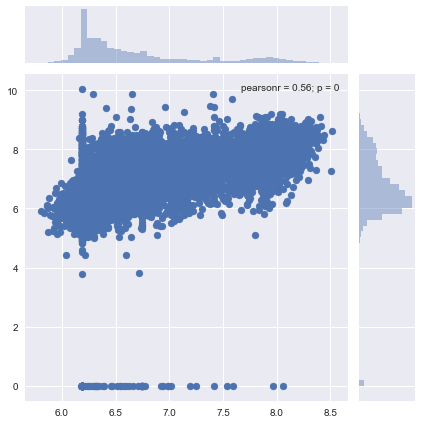

In [87]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32,32))

sns.jointplot(x=pred,y=y_test)

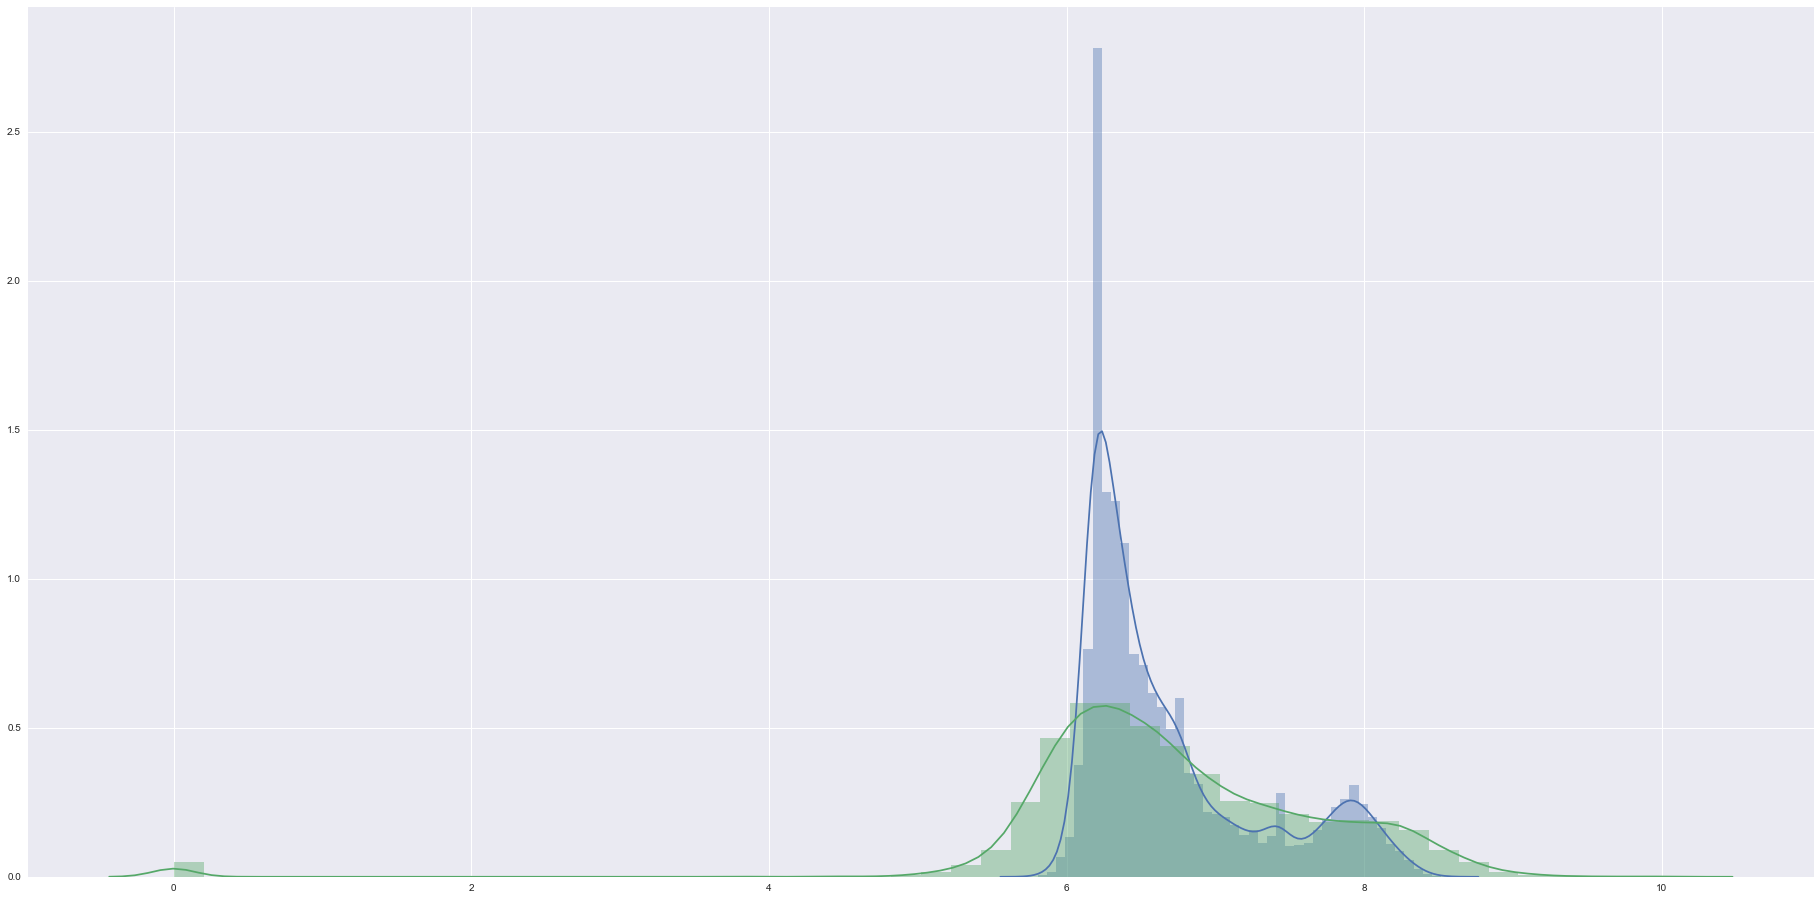

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(32,16))

error = pred - y_test.reshape(-1,1)

sns.distplot(pred)
sns.distplot(y_test)

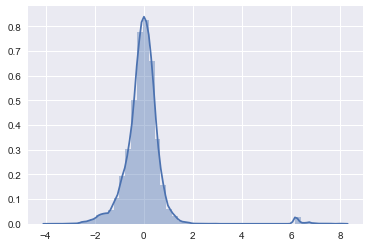

In [11]:
sns.distplot(error)

In [35]:
from scipy.stats import mode
from math import exp

max_income = max(pred)
min_income = min(pred)

print("MAX = ", max_income, exp(max_income))
print("MIN = ", min_income, exp(min_income))

MAX =  [ 8.51773357] 5002.702642651309
MIN =  [ 5.80553627] 332.1332587433977


In [45]:
arg_max_income = np.argmax(pred)
arg_min_income = np.argmin(pred)

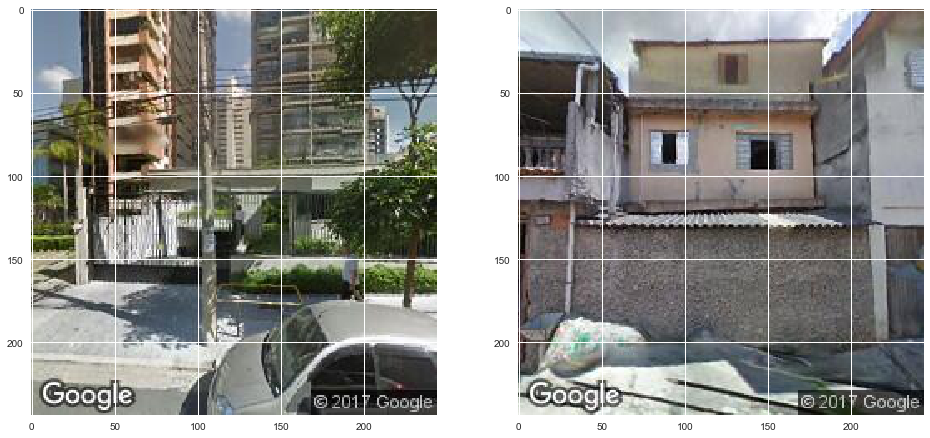

In [84]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches((16,8))

ax[0].imshow(x_test[arg_max_income,:]*255)
ax[1].imshow(x_test[arg_min_income,:]*255)

642.2858996948406


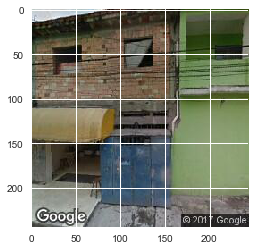

In [74]:
i = 9000
print(exp(pred[i]))
plt.imshow(x_test[i,:]*255)

In [75]:
np.sort(pred)

array([[ 6.37738514],
       [ 6.16673565],
       [ 6.25301266],
       ..., 
       [ 6.67863274],
       [ 6.18779469],
       [ 6.50239182]], dtype=float32)